In [89]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms

transform_test = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

transform_crossval = transforms.Compose([transforms.Resize(255),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

transform_train = transforms.Compose([transforms.Resize(255),
                                       transforms.RandomRotation(30),
                                       transforms.RandomGrayscale(0.2),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(0.25),
                                       transforms.RandomPerspective(),
                                       transforms.RandomVerticalFlip(0.15),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])

train_data = datasets.ImageFolder('./banana/train', transform=transform_train)
test_data = datasets.ImageFolder('./banana/test', transform=transform_test)
crossval_data = datasets.ImageFolder('./banana/val', transform=transform_crossval)

batch_size = 20
train_load = torch.utils.data.DataLoader(train_data,batch_size=batch_size, shuffle=True)
test_load = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)
crossval_load = torch.utils.data.DataLoader(crossval_data,batch_size=batch_size, shuffle=True)

#for images, labels in dataloader:
#    pass
#
#images, labels = next(iter(dataloader))

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.5, 0.5, 0.5])
        std = np.array([0.5, 0.5, 0.5])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

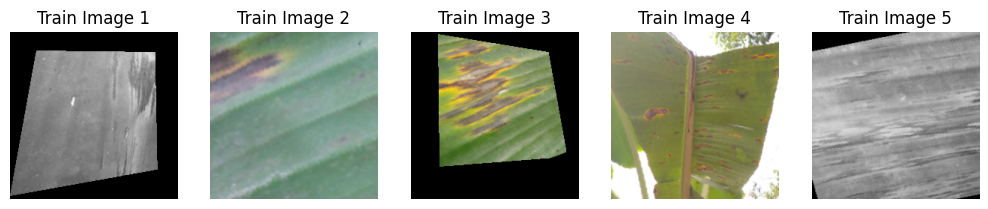

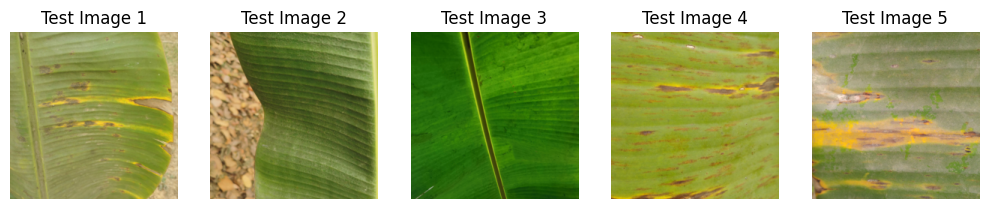

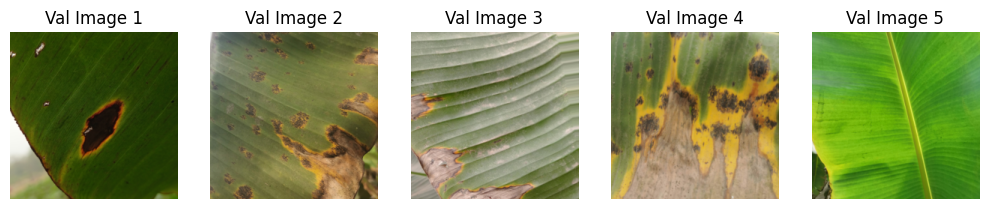

In [90]:

for loader_str, loader in [('Train Image', train_load), 
                           ('Test Image', test_load),
                           ('Val Image', crossval_load)]:
    data_iter = iter(loader)

    images, labels = next(data_iter)
    
    ncol = 5
    fig, axes = plt.subplots(figsize=(12.5,4),    
                                   ncols=ncol)

    for ii in range(ncol):
        ax = axes[ii]
        imshow(images[ii], 
               ax=ax, 
               normalize=True)
        ax.set_title('{} {}'.format(loader_str, ii+1))




In [91]:
import torch.nn as nn
import torchvision
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=4, padding=1)
        self.pool1 = nn.MaxPool2d(3,3)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=2, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(12)
        self.pool2 = nn.MaxPool2d(3,3)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(3,3)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=1, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*4*4, 4)

    def forward(self, input):
        output = F.relu(self.pool1(self.conv1(input)))      
        output = F.relu(self.bn1(self.conv2(output)))     
        output = self.pool2(output)                        
        output = F.relu(self.pool3(self.conv4(output)))     
        output = F.relu(self.bn2(self.conv5(output)))     
        output = output.view(-1, 24*4*4)
        output = self.fc1(output)

        return output

# Instantiate a neural network model 
model = Network()
classes = ('sigatoka', 'pestalotiopsis', 'healthy', 'cordana')

In [92]:
from torch.optim import Adam
 
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=0.01)

In [99]:
from torch.autograd import Variable

# Function to save the model

path = "./myFirstModel.pth"
torch.save(model.state_dict(), path)

# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in test_load:
            images, labels = data
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs, load):
    
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate((load), 0):
            
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 10 == 0:    
                # print every 1000 (twice per epoch) 
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                # zero the loss
                running_loss = 0.0

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        # we want to save the model if the accuracy is the best
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), path)
 
            best_accuracy = accuracy



In [100]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch(load):
    # get batch of images from the test DataLoader  
    images, labels = next(iter(load))

    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [101]:
if __name__ == "__main__":
    
    # Let's build our model
    train(15,train_load)
    print('Finished Training')

    #Cross-Validate
    testBatch(crossval_load)
    train(15,crossval_load)
    print('Finished Cross Validation')

    # Test which classes performed well
    print(testAccuracy())
    
    # Let's load the model we just created and test the accuracy per label
    model = Network()
    path = "myFirstModel.pth"
    model.load_state_dict(torch.load(path))

    # Test with batch of images
    testBatch(test_load)

The model will be running on cpu device
[1,     1] loss: 0.102
[1,    11] loss: 0.841
[1,    21] loss: 0.898
[1,    31] loss: 0.874
For epoch 1 the test accuracy over the whole test set is 67 %
[2,     1] loss: 0.092
[2,    11] loss: 0.838
[2,    21] loss: 0.810
[2,    31] loss: 0.821
For epoch 2 the test accuracy over the whole test set is 67 %
[3,     1] loss: 0.106
[3,    11] loss: 0.850
[3,    21] loss: 0.841
[3,    31] loss: 0.787
For epoch 3 the test accuracy over the whole test set is 67 %
[4,     1] loss: 0.060
[4,    11] loss: 0.876
[4,    21] loss: 0.836
[4,    31] loss: 0.862
For epoch 4 the test accuracy over the whole test set is 67 %
[5,     1] loss: 0.067
[5,    11] loss: 0.856
[5,    21] loss: 0.891
[5,    31] loss: 0.795
For epoch 5 the test accuracy over the whole test set is 67 %
[6,     1] loss: 0.091
[6,    11] loss: 0.771
[6,    21] loss: 0.822
[6,    31] loss: 0.897
For epoch 6 the test accuracy over the whole test set is 67 %
[7,     1] loss: 0.085
[7,    11] lo

In [102]:
# Function to test what classes performed well
def testClassess():
    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))
    with torch.no_grad():
        for data in test_load:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(batch_size):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(4):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

testClassess()

Accuracy of sigatoka : 35 %
Accuracy of pestalotiopsis : 75 %
Accuracy of healthy : 30 %
Accuracy of cordana : 90 %
